<b>Author:</b> ...

<b>Contributors:</b> ...


<div class="alert alert-block alert-info">
Before you start running this notebook, make sure you are using the Hail Genomics Analysis Environment. To do so,
<br/>
    
<ul>
    <li>Click on the <b>cloud analysis environment</b> icon on the righthand side of the screen.</li>
    <li>Inside <b>Recommended environments</b>, select <b>Hail Genomics Analysis</b> which creates a cloud environment for your analyses.</li>
    <li>This analysis can be run with <b>low compute</b> (e.g. 2 workers with 4 CPUs, 15 GB of RAM).</li>
    <li>Click on <b>Next</b>.</li>
</ul>
    
</div>

<h1>Notebook Objectives</h1>

This notebook produces the PCA panel of Figure 1 in the AoU-LR manuscript.

<b>How to Use this Notebook...</b>

<b>As a tutorial:</b>

...

<b>As a resource:</b>

...

<h2>Relevant Information:</h2>

...

## Set up environment

In [1]:
import hail as hl
from hail.plot import show

Loading BokehJS ...

In [2]:
import os
import numpy as np
from collections import Counter

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d

In [4]:
bucket = os.environ['WORKSPACE_BUCKET'] if 'WORKSPACE_BUCKET' in os.environ else ''
workspace = os.environ['WORKSPACE_NAME'] if 'WORKSPACE_NAME' in os.environ else ''
namespace = os.environ['WORKSPACE_NAMESPACE'] if 'WORKSPACE_NAMESPACE' in os.environ else ''

## List samples

### List PacBio samples with additional ONT data

In [5]:
ont_ids = ['1000513', '1000920', '1001399', '1001980', '1002322', '1002826', '1004266', '1005038', '1005444',
           '1005938', '1007198', '1008775', '1010384', '1012440', '1012736', '1013536', '1014457', '1014625',
           '1014694', '1014764', '1014823', '1015059', '1015507', '1016971', '1016985', '1019345', '1024761',
           '1025136', '1025342', '1025566', '1025694', '1026351', '1026529', '1026622', '1027488', '1027673', 
           '1029520', '1029873', '1032052', '1032684', '1036042', '1037292', '1037774', '1037790', '1037792', 
           '1037950', '1041753', '1042609', '1044452', '1048940']
len(ont_ids)

50

### List AoU+HPRC long-read samples

In [6]:
all_ids = !gsutil cat {bucket}/bam_csv/1074_bams.csv | cut -d',' -f1
len(all_ids)

1074

### List AoU long-read samples

In [7]:
pb_ids = !gsutil cat {bucket}/bam_csv/1074_bams.csv | grep -v HPRC | cut -d',' -f1
len(pb_ids)

1027

### List HPRC long-read samples

In [8]:
hprc_ids = !gsutil cat {bucket}/bam_csv/1074_bams.csv | grep HPRC | cut -d',' -f1
len(hprc_ids)

47

## Stage data

### Expand AoU ancestry predictions tarball and stage

In [9]:
!gsutil -u $GOOGLE_PROJECT -m cp -r gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht.tar.gz .
!gunzip -c delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht.tar.gz | tar xvf -
!gsutil -m cp -r delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht {bucket}/scratch/kvg/

Copying gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht.tar.gz...
- [1/1 files][ 31.1 MiB/ 31.1 MiB] 100% Done                                    
Operation completed over 1 objects/31.1 MiB.                                     
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/_SUCCESS
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/README.txt
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/.README.txt.crc
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/._SUCCESS.crc
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/rows/
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/rows/parts/
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/rows/parts/.part-02-10-2-0-b8f9f6b0-f6b8-cec2-5b78-ccf3e6e0a1a9.crc
delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/ro

Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/README.txt [Content-Type=text/plain]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/.metadata.json.gz.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/._SUCCESS.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/metadata.json.gz [Content-Type=application/json]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/_SUCCESS [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/.README.txt.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-00-10-0-0-9eeac40b-f55b-ae29-c8c7-897d75ad010c.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-00-10-0-0-9eeac40b-f55b-a

Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/rows/parts/part-14-10-14-0-bf6d582a-ecea-e0de-4da3-e5155d102239 [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/rows/parts/.part-00-10-0-0-9eeac40b-f55b-ae29-c8c7-897d75ad010c.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-13-10-13-0-2d465b08-3b0f-1bd0-8000-d3632431c5ed.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-13-10-13-0-2d465b08-3b0f-1bd0-8000-d3632431c5ed.idx/.metadata.json.gz.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-10-10-10-0-a40db25e-91f9-4e73-e91b-0a5f6f575b48.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.ht/index/part-13-10-13-0-2d465b08-3b0

| [108/108 files][ 33.3 MiB/ 33.3 MiB] 100% Done                                
Operation completed over 108 objects/33.3 MiB.                                   


### Expand AoU PCA loadings tarball and stage

In [10]:
!gsutil -u $GOOGLE_PROJECT -m cp -r gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht.tar.gz .
!gunzip -c delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht.tar.gz | tar xvf -
!gsutil -m cp -r delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht {bucket}/scratch/kvg/

Copying gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht.tar.gz...
/ [1/1 files][ 20.7 MiB/ 20.7 MiB] 100% Done                                    
Operation completed over 1 objects/20.7 MiB.                                     
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/_SUCCESS
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/README.txt
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/.README.txt.crc
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/._SUCCESS.crc
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/.part-15-1-15-0-89dc7f66-a3cc-65f1-e047-e908f9211757.crc
delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/.part-07-1-7-0-a2f5b90f-9b30-b3f2-1b1d-f94bb79f819d

Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/README.txt [Content-Type=text/plain]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/.metadata.json.gz.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/._SUCCESS.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/metadata.json.gz [Content-Type=application/json]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/_SUCCESS [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/.README.txt.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-15-1-15-0-89dc7f66-a3cc-65f1-e047-e908f9211757.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-15-1-15-0-89dc7f66-a3cc-65f1-e047-e908f9211757.idx/.metadata.json.gz.crc 

Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/part-13-1-13-0-3df36501-b609-97e2-e8d5-478d831b4ae6 [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-18-1-18-0-75e50ee5-b684-3b65-abb7-aedcce3dddcf.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-02-1-2-0-2844e176-d69a-fdea-267b-9cdf4f607a7e.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-18-1-18-0-75e50ee5-b684-3b65-abb7-aedcce3dddcf.idx/.metadata.json.gz.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-04-1-4-0-3b60bd12-e4f6-c02e-1fdc-cc3670c4e8a2.idx/.metadata.json.gz.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-18-1-18-0-75e50ee5-b684-3b65-abb7-aedcce3dddcf.id

Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-30-1-30-0-92b9c31a-463c-898e-16d0-f0160125a0ff.idx/.index.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-02-1-2-0-2844e176-d69a-fdea-267b-9cdf4f607a7e.idx/.index.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-02-1-2-0-2844e176-d69a-fdea-267b-9cdf4f607a7e.idx/metadata.json.gz [Content-Type=application/json]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/part-30-1-30-0-92b9c31a-463c-898e-16d0-f0160125a0ff [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-30-1-30-0-92b9c31a-463c-898e-16d0-f0160125a0ff.idx/index [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/index/part-30-1-30-0-92b9c31a-463c-898e-16d0-f0160125a0ff.idx/metadata.json.gz 

Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/.part-19-1-19-0-fbda0dd9-88c8-0324-ae53-5d5da773d2b6.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/part-01-1-1-0-bff7f937-142b-1e7d-e406-fdbda07163b8 [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/.part-20-1-20-0-746cfba4-d21f-2269-41a7-4c77b02ebe4d.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/part-11-1-11-0-9f15a917-422d-d572-9c77-1919a42e753d [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/.part-15-1-15-0-89dc7f66-a3cc-65f1-e047-e908f9211757.crc [Content-Type=application/octet-stream]...
Copying file://delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/rows/parts/part-12-1-12-0-110d9e0e-f663-8e51-e937-b6fe5257a7bb [Content-Type=application/octet-s

### Download ancestry predictions

In [11]:
!gsutil -u $GOOGLE_PROJECT -m cp -r gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv .

Copying gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv...
\ [1/1 files][ 96.7 MiB/ 96.7 MiB] 100% Done                                    
Operation completed over 1 objects/96.7 MiB.                                     


### Download eigenvalues

In [12]:
!gsutil cp gs://fc-secure-238cb4eb-b816-4a44-a612-ce7d677bf686/delta_PCA/delta_PCA.eigenvalues.ht delta_PCA.eigenvalues.txt

Copying gs://fc-secure-238cb4eb-b816-4a44-a612-ce7d677bf686/delta_PCA/delta_PCA.eigenvalues.ht...
/ [1 files][  295.0 B/  295.0 B]                                                
Operation completed over 1 objects/295.0 B.                                      


In [13]:
eigenvalues_txt = f'delta_PCA.eigenvalues.txt'

with open(eigenvalues_txt, 'r') as file:
    eigenvalues = [float(line.strip()) for line in file]
    
eigenvalues = eigenvalues[1:]
total_variance = sum(eigenvalues)
variance_explained = [eig / total_variance for eig in eigenvalues]

variance_explained

[0.460214936825472,
 0.1725779339757019,
 0.08082587502976771,
 0.04910022602566959,
 0.03837360100835058,
 0.023429488947018507,
 0.021474408883113454,
 0.01937726965715581,
 0.019177524029063586,
 0.01728083532393867,
 0.016788934676327468,
 0.01641056446537676,
 0.016353752986068015,
 0.016262250747781776,
 0.016204637537205097,
 0.016147759881988924]

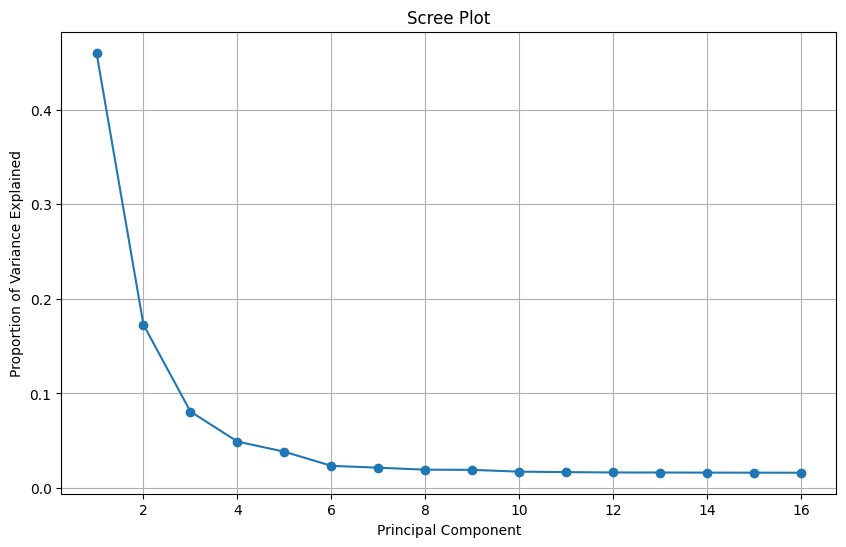

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), variance_explained, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True)
plt.show()

## Project HPRC samples into AoU's PCA space

In [15]:
hl.init()

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://saturn-f75e1fa5-6fbc-4dc6-ae19-602e6c4dd082-m.us-central1-c.c.terra-7a376e4e.internal:35051
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing to /home/jupyter/AoU_DRC_WGS_LongReads_PacBio/edit/hail-20250328-0825-0.2.130.post1-c69cd67afb8b.log


In [16]:
hl.default_reference('GRCh38')

In [17]:
loadings = hl.read_table(f'{bucket}/scratch/kvg/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht')

In [18]:
loadings.show(10)

,,,
locus,alleles,loadings,af
locus<GRCh38>,array<str>,array<float64>,float64
chr1:924249,"[""G"",""A""]","[-1.22e-03,-2.28e-05,-1.04e-04,-4.10e-04,4.06e-03,6.83e-04,-1.18e-03,-1.20e-03,-4.17e-04,4.51e-03,-4.71e-03,-3.99e-03,-5.71e-03,8.79e-04,-1.13e-03,-1.76e-03]",1.15e-03
chr1:924704,"[""C"",""T""]","[-1.42e-03,-1.08e-04,2.91e-05,-2.62e-06,3.98e-03,2.47e-03,-1.77e-03,1.06e-03,-7.12e-04,5.70e-03,-7.75e-03,1.08e-03,1.72e-04,-8.66e-03,1.25e-03,-3.05e-03]",1.14e-03
chr1:930204,"[""G"",""A""]","[-3.57e-03,-2.66e-05,3.82e-04,3.37e-04,3.07e-03,-2.57e-03,3.00e-03,1.74e-03,-7.79e-04,2.79e-03,-1.92e-03,1.83e-03,-6.11e-04,7.32e-03,-4.73e-04,-1.63e-03]",9.39e-03
chr1:930245,"[""G"",""A""]","[-1.20e-03,1.56e-04,-4.44e-05,3.92e-04,-3.82e-04,-7.72e-04,1.21e-04,-2.68e-03,-3.08e-03,4.20e-04,2.35e-04,1.51e-03,1.92e-03,2.02e-03,4.64e-03,-3.71e-03]",1.27e-03
chr1:930248,"[""G"",""A""]","[5.83e-04,1.58e-03,3.03e-04,1.74e-05,-1.33e-04,-3.56e-03,-4.99e-03,1.05e-03,2.28e-04,-1.61e-04,5.93e-05,3.88e-05,1.11e-04,2.16e-05,-3.43e-05,3.20e-05]",3.17e-03
chr1:930314,"[""C"",""T""]","[1.83e-03,-7.79e-03,5.74e-03,2.33e-03,-3.06e-04,-4.43e-04,-1.32e-03,-1.04e-03,-7.99e-04,2.67e-04,-2.27e-03,-1.87e-03,1.02e-03,-2.61e-04,-2.92e-04,1.61e-03]",5.52e-02
chr1:930325,"[""C"",""T""]","[-2.03e-03,-1.32e-04,-1.24e-05,1.18e-04,-2.76e-03,1.22e-03,-1.36e-03,-4.89e-03,-3.73e-03,-1.44e-02,-6.66e-03,-3.00e-03,6.91e-04,-1.33e-03,2.59e-03,8.44e-05]",2.41e-03
chr1:931042,"[""C"",""T""]","[-1.56e-03,1.87e-04,4.95e-04,3.26e-04,1.91e-03,-1.94e-03,4.82e-04,-1.72e-04,-1.98e-03,1.38e-03,1.09e-03,-1.79e-03,2.73e-03,-3.97e-03,-1.51e-03,1.89e-03]",2.79e-03


In [19]:
ancestry_preds_tbl = hl.import_table(
    'gs://fc-secure-69d71149-7f02-4dec-a16b-049ec77f305a/submissions/9ab5854f-114a-4a4b-89c8-adc5f92287a8/run_ancestry/21877db0-9cd0-4c5e-a79f-2eb22d3fa363/call-call_ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv',
    types={ 'pca_features': hl.tarray(hl.tfloat64) }
)

ancestry_preds_tbl.show(10)

2025-03-28 08:26:35.384 Hail: INFO: Reading table without type imputation
  Loading field 'research_id' as type str (not specified)
  Loading field 'ancestry_pred' as type str (not specified)
  Loading field 'probabilities' as type str (not specified)
  Loading field 'pca_features' as type array<float64> (user-supplied)
  Loading field 'ancestry_pred_other' as type str (not specified)


,,,,
research_id,ancestry_pred,probabilities,pca_features,ancestry_pred_other
str,str,str,array<float64>,str
"""1000004""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[1.01e-01,1.36e-01,-6.32e-03,5.22e-02,3.26e-03,1.63e-02,1.60e-02,-2.15e-03,-1.44e-03,1.01e-03,1.43e-03,-5.13e-04,5.04e-05,-6.64e-04,8.59e-04,-1.32e-03]","""eur"""
"""1000033""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[9.83e-02,1.25e-01,-9.63e-03,4.32e-02,3.48e-03,2.08e-02,2.26e-02,-2.58e-03,-1.35e-03,6.19e-05,-1.37e-04,4.62e-04,4.82e-04,7.05e-04,6.07e-04,8.18e-04]","""eur"""
"""1000039""","""afr""","""[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]""","[-2.66e-01,4.73e-03,-1.06e-03,1.81e-03,3.15e-02,2.32e-03,6.27e-03,1.32e-02,-1.83e-03,2.63e-03,-1.64e-03,6.89e-03,3.55e-03,2.39e-03,4.75e-03,4.30e-03]","""afr"""
"""1000042""","""afr""","""[0.98, 0.01, 0.0, 0.0, 0.0, 0.01]""","[-2.55e-01,5.97e-03,2.74e-03,8.75e-03,1.02e-02,9.69e-03,-6.93e-04,-2.68e-03,1.04e-02,6.88e-03,3.77e-03,-3.04e-03,-2.77e-03,9.05e-04,2.44e-03,5.67e-03]","""afr"""
"""1000045""","""eas""","""[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]""","[9.73e-02,-1.58e-01,-4.39e-02,3.49e-02,-3.16e-04,-4.19e-03,-3.38e-03,8.09e-04,-1.32e-04,-8.36e-04,2.06e-04,1.80e-04,9.49e-05,-5.99e-04,4.56e-04,-7.37e-04]","""eas"""
"""1000059""","""eur""","""[0.0, 0.01, 0.13, 0.86, 0.0, 0.0]""","[1.01e-01,1.29e-01,-3.49e-03,4.23e-02,1.63e-03,1.31e-02,1.42e-02,-2.32e-03,-3.60e-04,-4.94e-04,2.24e-04,-2.09e-03,8.47e-04,-3.23e-04,4.63e-04,-3.10e-04]","""eur"""
"""1000061""","""eur""","""[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]""","[1.01e-01,1.33e-01,-1.25e-02,4.67e-02,2.54e-03,1.95e-02,2.18e-02,-4.58e-03,-1.88e-03,9.15e-05,-5.87e-04,-2.96e-04,-7.70e-05,-9.73e-04,4.11e-05,-1.93e-03]","""eur"""
"""1000070""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[1.01e-01,1.34e-01,-1.11e-02,4.71e-02,2.32e-03,1.92e-02,2.22e-02,-3.75e-03,-2.57e-03,1.39e-06,-2.10e-04,-1.37e-03,-1.88e-04,-5.19e-04,1.80e-03,7.31e-05]","""eur"""


In [20]:
l1 = ancestry_preds_tbl.ancestry_pred_other.collect()

In [21]:
ancestry_preds_pb_tbl = ancestry_preds_tbl.filter(hl.literal(pb_ids).contains(ancestry_preds_tbl.research_id))
l2 = ancestry_preds_pb_tbl.ancestry_pred_other.collect()

In [22]:
ancestry_preds_ont_tbl = ancestry_preds_tbl.filter(hl.literal(ont_ids).contains(ancestry_preds_tbl.research_id))
o2 = ancestry_preds_ont_tbl.ancestry_pred_other.collect()

In [23]:
hprc_gvcf = 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/submissions/a8e7a923-0f2d-4c5d-b0d5-433510d7d4e8/LRJointCallGVCFs/8449b2e3-833a-4de7-811e-274bf99ea1cf/call-JointCall/JointCall/dd80eb72-ee34-4f48-a104-72e3a262131d/call-ConcatBCFs/HPRC_samples.g.vcf.bgz'

In [24]:
# hprc_mt = hl.import_vcf(
#     hprc_gvcf,
#     array_elements_required=False,
#     force_bgz=True
# )

# hprc_mt.write(f'{bucket}/scratch/kvg/hprc-47.mt')

In [25]:
#grch38_mt = hl.read_matrix_table(f'{bucket}/scratch/kvg/hprc-47.mt')
#testing_ht = hl.experimental.pc_project(grch38_mt.GT, loadings.loadings, loadings.af)
#testing_ht.write(f'{bucket}/scratch/kvg/HPRC.projected.ht', overwrite=True)

In [24]:
testing_ht = hl.read_table(f'{bucket}/scratch/kvg/HPRC.projected.ht')

In [25]:
testing_ht.show(5)

,
s,scores
str,array<float64>
"""HG002""","[7.92e-02,1.13e-01,-1.91e-02,2.13e-02,1.95e-03,-2.76e-02,-3.45e-02,7.51e-03,1.36e-04,-4.07e-04,1.37e-03,9.40e-04,-7.79e-04,-2.41e-04,-1.68e-04,-2.66e-04]"
"""HG00438""","[8.84e-02,-1.48e-01,-4.14e-02,4.62e-02,4.20e-03,-3.05e-03,-7.12e-04,2.25e-03,-1.02e-03,-1.39e-03,2.77e-04,2.11e-03,-1.43e-04,-7.82e-04,-6.67e-05,-4.49e-04]"
"""HG005""","[9.03e-02,-1.50e-01,-3.82e-02,4.50e-02,3.95e-03,-1.95e-03,-1.75e-03,1.97e-03,-1.91e-03,-8.10e-04,7.83e-05,8.78e-04,-6.33e-04,-8.64e-04,1.77e-04,4.62e-04]"
"""HG00621""","[9.21e-02,-1.52e-01,-3.72e-02,4.41e-02,3.56e-03,-3.72e-03,-5.14e-04,1.65e-05,-2.49e-03,-1.59e-03,-2.52e-04,2.19e-04,-7.13e-04,-7.24e-04,1.58e-04,-1.82e-03]"
"""HG00673""","[9.09e-02,-1.55e-01,-4.62e-02,4.63e-02,3.21e-03,-2.20e-03,-6.36e-04,1.02e-03,-2.46e-03,-5.27e-04,7.79e-04,3.16e-05,-4.94e-04,-1.73e-04,1.77e-03,-6.39e-04]"


In [26]:
pc1 = ancestry_preds_tbl.pca_features[0].collect()
pc2 = ancestry_preds_tbl.pca_features[1].collect()
pc3 = ancestry_preds_tbl.pca_features[2].collect()

pb_pc1 = ancestry_preds_pb_tbl.pca_features[0].collect()
pb_pc2 = ancestry_preds_pb_tbl.pca_features[1].collect()
pb_pc3 = ancestry_preds_pb_tbl.pca_features[2].collect()

ont_pc1 = ancestry_preds_ont_tbl.pca_features[0].collect()
ont_pc2 = ancestry_preds_ont_tbl.pca_features[1].collect()
ont_pc3 = ancestry_preds_ont_tbl.pca_features[2].collect()

hprc_pc1 = testing_ht.scores[0].collect()
hprc_pc2 = testing_ht.scores[1].collect()
hprc_pc3 = testing_ht.scores[2].collect()

In [27]:
len(pc1)

245394

## Plot PCA

In [28]:
color_map = {
    'afr': '#D573BE',
    'amr': '#519D3E',
    'eas': '#C53A32',
    'eur': '#3976AF',
    'mid': '#EF8536',
    'sas': '#866BE8',
    'oth': '#84584E'
}

grey_map = {
    'afr': '#CCCCCC',
    'amr': '#CCCCCC',
    'eas': '#CCCCCC',
    'eur': '#CCCCCC',
    'mid': '#CCCCCC',
    'sas': '#CCCCCC',
    'oth': '#CCCCCC'
}

outer_color = "#333333"

pb_color = "#FFFFFF"
pb_ont_color = "#45B29D"

hprc_color = "#FFE11A"
hprc_outer_color = "#FFF22B"

In [29]:
pip install adjustText


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


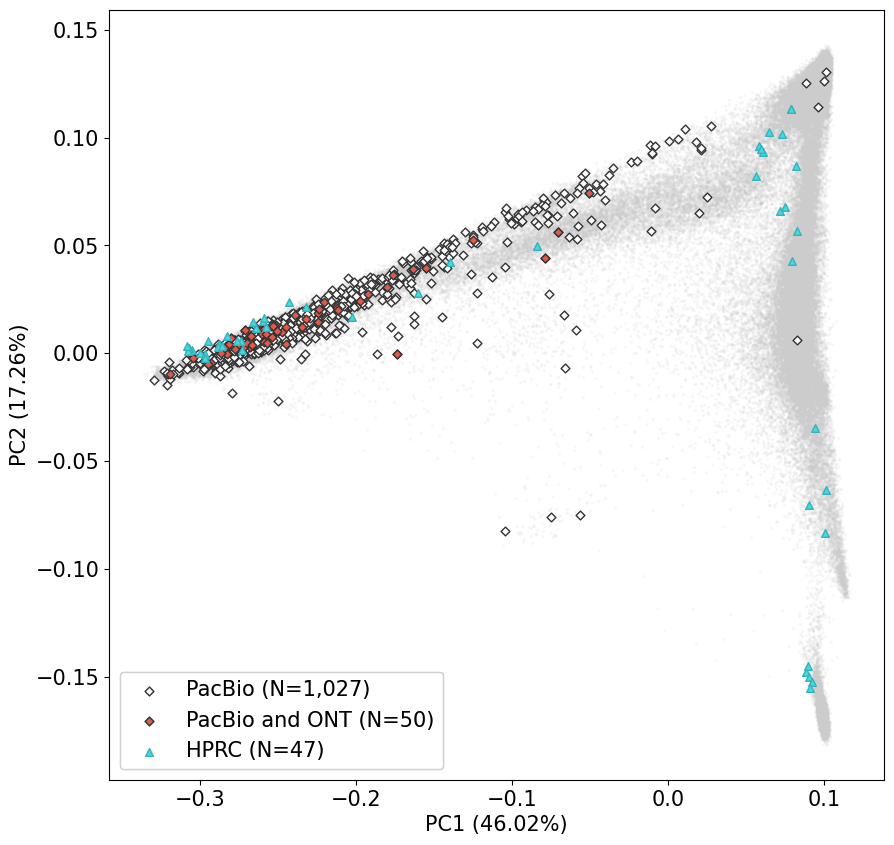

In [30]:
from adjustText import adjust_text

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

# Create a scatter plot for each population in the full dataset
for pop, color in grey_map.items():
    # Filter points belonging to the current population
    indices = [i for i, item in enumerate(l1) if item == pop]
    plt.scatter(
        [pc1[i] for i in indices],
        [pc2[i] for i in indices],
        color=color,
        alpha=0.1,
        s=2,
        label=pop  # Label for legend
    )

a1 = plt.scatter([pb_pc1[0]], [pb_pc2[0]], marker="D", edgecolor=outer_color, color=pb_color, s=20, label='PacBio (N=1,027)')
a2 = plt.scatter([ont_pc1[0]], [ont_pc2[0]], marker="D", edgecolor=outer_color, color="#DF5A49", s=20, label='PacBio and ONT (N=50)')
a3 = plt.scatter([hprc_pc1[0]], [hprc_pc2[0]], marker="^", edgecolor="#36B1BF", color="#4AD9D9", s=30, label='HPRC (N=47)')
    
plt.scatter(
    pb_pc1,
    pb_pc2,
    marker="D",
    edgecolor=outer_color,
    color=pb_color,
    s=20
)

plt.scatter(
    ont_pc1,
    ont_pc2,
    marker="D",
    edgecolor=outer_color,
    color="#DF5A49",
    s=20
)
        
plt.scatter(
    hprc_pc1,
    hprc_pc2,
    marker="^",
    edgecolor="#36B1BF",
    color="#4AD9D9",
    s=30
)
    
plt.xlabel(f"PC1 ({100.0*variance_explained[0]:.2f}%)")
plt.ylabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)")

legend2 = plt.legend(handles=[a1, a2, a3], loc='lower left')
plt.gca().add_artist(legend2)

plt.savefig('pca_2d_grey.proj.pdf', format='pdf', bbox_inches='tight')

plt.show()

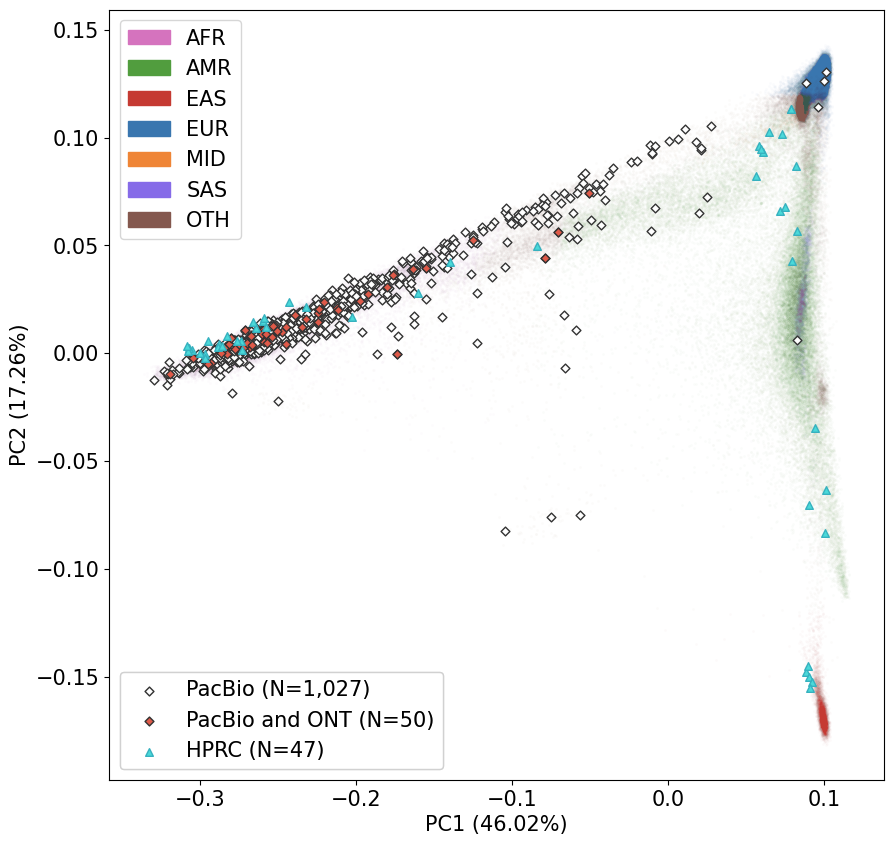

In [42]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

# Create a scatter plot for each population in the full dataset
for pop, color in color_map.items():
    # Filter points belonging to the current population
    indices = [i for i, item in enumerate(l1) if item == pop]
    plt.scatter(
        [pc1[i] for i in indices],
        [pc2[i] for i in indices],
        color=color,
        alpha=0.01,
        s=2,
        label=pop  # Label for legend
    )

# a1 = plt.scatter([pb_pc1[0]], [pb_pc2[0]], marker="D", edgecolor=outer_color, color=pb_color, s=20, label='PacBio (N=1,027)')
# a2 = plt.scatter([ont_pc1[0]], [ont_pc2[0]], marker="D", edgecolor=outer_color, color=pb_ont_color, s=20, label='PacBio and ONT (N=50)')
# a3 = plt.scatter([hprc_pc1[0]], [hprc_pc2[0]], marker="^", edgecolor=hprc_outer_color, color=hprc_color, s=20, label='HPRC (N=47)')

a1 = plt.scatter([pb_pc1[0]], [pb_pc2[0]], marker="D", edgecolor=outer_color, color=pb_color, s=20, label='PacBio (N=1,027)')
a2 = plt.scatter([ont_pc1[0]], [ont_pc2[0]], marker="D", edgecolor=outer_color, color="#DF5A49", s=20, label='PacBio and ONT (N=50)')
a3 = plt.scatter([hprc_pc1[0]], [hprc_pc2[0]], marker="^", edgecolor="#36B1BF", color="#4AD9D9", s=30, label='HPRC (N=47)')

plt.scatter(
    pb_pc1,
    pb_pc2,
    marker="D",
    edgecolor=outer_color,
    color=pb_color,
    s=20
)

plt.scatter(
    ont_pc1,
    ont_pc2,
    marker="D",
#     edgecolor=outer_color,
#     color=pb_ont_color,
    edgecolor=outer_color,
    color="#DF5A49",
    s=20
)
        
plt.scatter(
    hprc_pc1,
    hprc_pc2,
    marker="^",
#     edgecolor=hprc_outer_color,
#     color=hprc_color,
    edgecolor="#36B1BF",
    color="#4AD9D9",    
    s=30
)

plt.xlabel(f"PC1 ({100.0*variance_explained[0]:.2f}%)")
plt.ylabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)")

legend1_patches = [mpatches.Patch(color=color, label=pop.upper()) for pop, color in color_map.items()]
legend1 = plt.legend(handles=legend1_patches)
plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[a1, a2, a3], loc='lower left')
plt.gca().add_artist(legend2)

plt.savefig('pca_2d.proj.pdf', format='pdf', bbox_inches='tight')

plt.show()

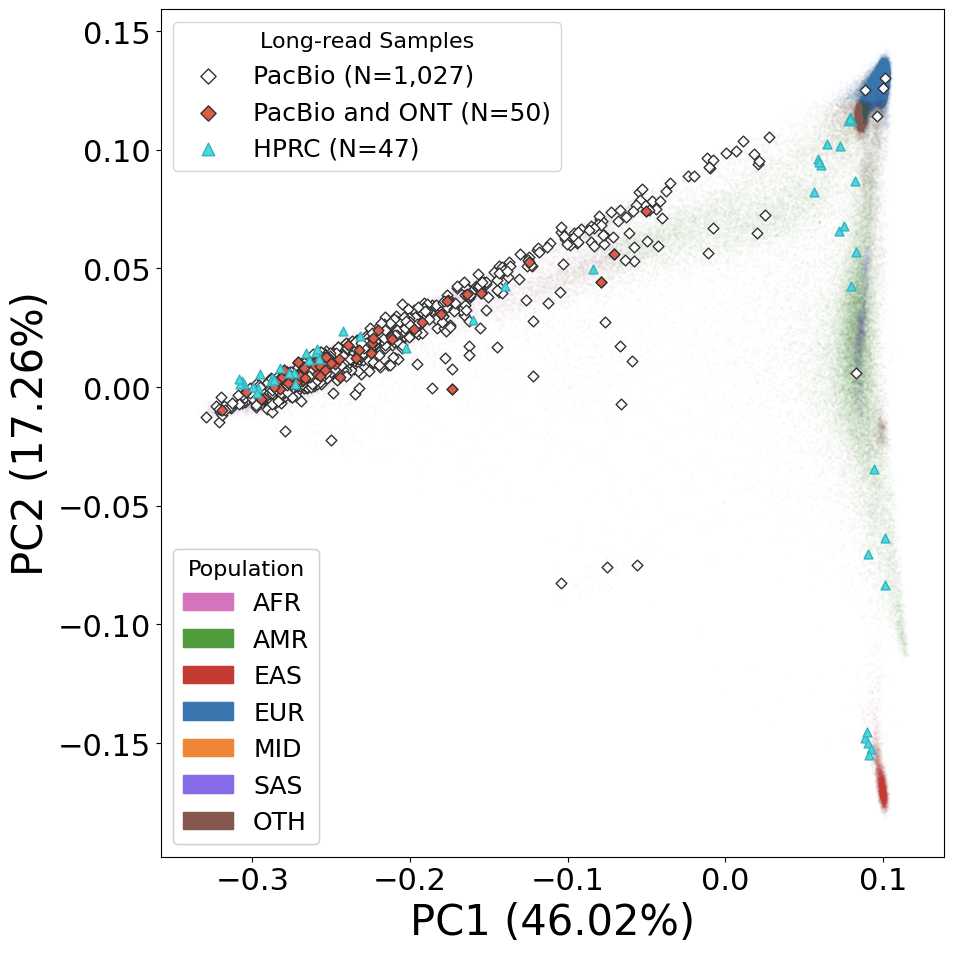

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 22})  # Increased base font size

# Create a scatter plot for each population in the full dataset
for pop, color in color_map.items():
    indices = [i for i, item in enumerate(l1) if item == pop]
    plt.scatter(
        [pc1[i] for i in indices],
        [pc2[i] for i in indices],
        color=color,
        alpha=0.01,
        s=2,
        label=pop
    )

# Key points
a1 = plt.scatter([pb_pc1[0]], [pb_pc2[0]], marker="D", edgecolor=outer_color, color=pb_color, s=60, label='PacBio (N=1,027)')
a2 = plt.scatter([ont_pc1[0]], [ont_pc2[0]], marker="D", edgecolor=outer_color, color="#DF5A49", s=60, label='PacBio and ONT (N=50)')
a3 = plt.scatter([hprc_pc1[0]], [hprc_pc2[0]], marker="^", edgecolor="#36B1BF", color="#4AD9D9", s=80, label='HPRC (N=47)')

# Full datasets
plt.scatter(pb_pc1, pb_pc2, marker="D", edgecolor=outer_color, color=pb_color, s=30)
plt.scatter(ont_pc1, ont_pc2, marker="D", edgecolor=outer_color, color="#DF5A49", s=30)
plt.scatter(hprc_pc1, hprc_pc2, marker="^", edgecolor="#36B1BF", color="#4AD9D9", s=40)

# Axis labels
plt.xlabel(f"PC1 ({100.0*variance_explained[0]:.2f}%)", fontsize=30)
plt.ylabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)", fontsize=30)

# Swapped legend positions
legend2 = plt.legend(handles=[a1, a2, a3], loc='upper left', fontsize=18, title="Long-read Samples", title_fontsize=16)
plt.gca().add_artist(legend2)

legend1_patches = [mpatches.Patch(color=color, label=pop.upper()) for pop, color in color_map.items()]
legend1 = plt.legend(handles=legend1_patches, loc='lower left', fontsize=18, title="Population", title_fontsize=16)
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig('pca_2d.proj.pdf', format='pdf', bbox_inches='tight')
plt.show()

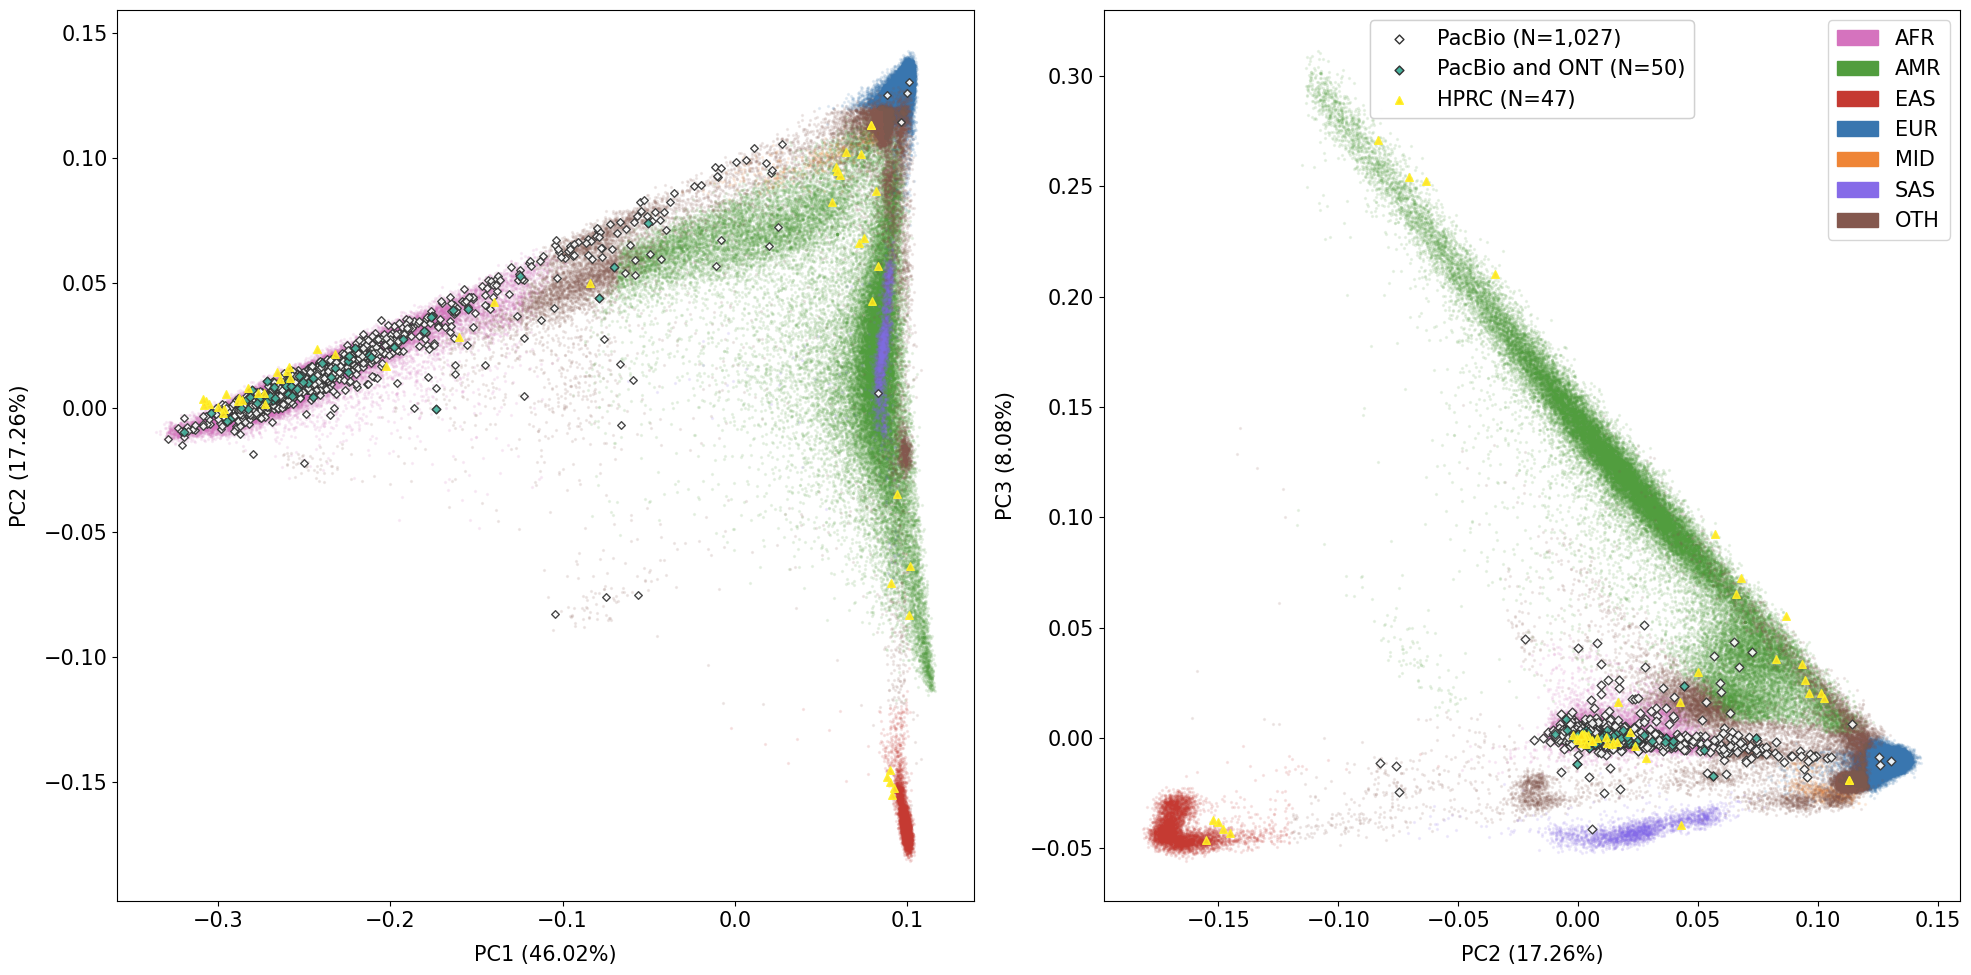

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
colors = [color_map[item] for item in l1]

# Create a scatter plot for each population in the full dataset
for pop, color in color_map.items():
    # Filter points belonging to the current population
    indices = [i for i, item in enumerate(l1) if item == pop]
    ax1.scatter(
        [pc1[i] for i in indices],
        [pc2[i] for i in indices],
        color=color,
        alpha=0.1,
        s=2,
        label=pop  # Label for legend
    )

a1 = ax1.scatter([pb_pc1[0]], [pb_pc2[0]], marker="D", edgecolor=outer_color, color=pb_color, s=20, label='PacBio (N=1,027)')
a2 = ax1.scatter([ont_pc1[0]], [ont_pc2[0]], marker="D", edgecolor=outer_color, color=pb_ont_color, s=20, label='PacBio and ONT (N=50)')
a3 = ax1.scatter([hprc_pc1[0]], [hprc_pc2[0]], marker="^", edgecolor=hprc_outer_color, color=hprc_color, s=30, label='HPRC (N=47)')
    
ax1.scatter(
    pb_pc1,
    pb_pc2,
    marker="D",
    color=pb_color,
    edgecolor=outer_color,
    alpha=0.9,
    s=15
)

ax1.scatter(
    ont_pc1,
    ont_pc2,
    marker="D",
    color=pb_ont_color,
    edgecolor=outer_color,
    alpha=0.9,
    s=20
)

ax1.scatter(
    hprc_pc1,
    hprc_pc2,
    marker="^",
    color=hprc_color,
    edgecolor=hprc_outer_color,
    alpha=0.9,
    s=30
)

ax1.set_xlabel(f"PC1 ({100.0*variance_explained[0]:.2f}%)", labelpad=10)
ax1.set_ylabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)", labelpad=10)

# Create a scatter plot for each population in the full dataset
for pop, color in color_map.items():
    # Filter points belonging to the current population
    indices = [i for i, item in enumerate(l1) if item == pop]
    plt.scatter(
        [pc2[i] for i in indices],
        [pc3[i] for i in indices],
        color=color,
        alpha=0.1,
        s=2,
        label=pop  # Label for legend
    )

a1 = ax2.scatter([pb_pc2[0]], [pb_pc3[0]], marker="D", edgecolor=outer_color, color=pb_color, s=20, label='PacBio (N=1,027)')
a2 = ax2.scatter([ont_pc2[0]], [ont_pc3[0]], marker="D", edgecolor=outer_color, color=pb_ont_color, s=20, label='PacBio and ONT (N=50)')
a3 = ax2.scatter([hprc_pc2[0]], [hprc_pc3[0]], marker="^", edgecolor=hprc_outer_color, color=hprc_color, s=30, label='HPRC (N=47)')

ax2.scatter(
    pb_pc2,
    pb_pc3,
    marker="D",
    color=pb_color,
    edgecolor=outer_color,
    alpha=0.9,
    s=20
)

ax2.scatter(
    ont_pc2,
    ont_pc3,
    marker="D",
    color=pb_ont_color,
    edgecolor=outer_color,
    alpha=0.9,
    s=20
)

ax2.scatter(
    hprc_pc2,
    hprc_pc3,
    marker="^",
    color=hprc_color,
    edgecolor=hprc_outer_color,
    alpha=0.9,
    s=30
)

ax2.set_xlabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)", labelpad=10)
ax2.set_ylabel(f"PC3 ({100.0*variance_explained[2]:.2f}%)", labelpad=10)

legend_patches = [mpatches.Patch(color=color, label=pop.upper()) for pop, color in color_map.items()]
legend1 = ax2.legend(handles=legend_patches)
plt.gca().add_artist(legend1)

legend2 = ax2.legend(handles=[a1, a2, a3], loc='upper center')
plt.gca().add_artist(legend2)

plt.tight_layout()

plt.savefig('pca_two_panel.proj.pdf', format='pdf', bbox_inches='tight')

plt.show()

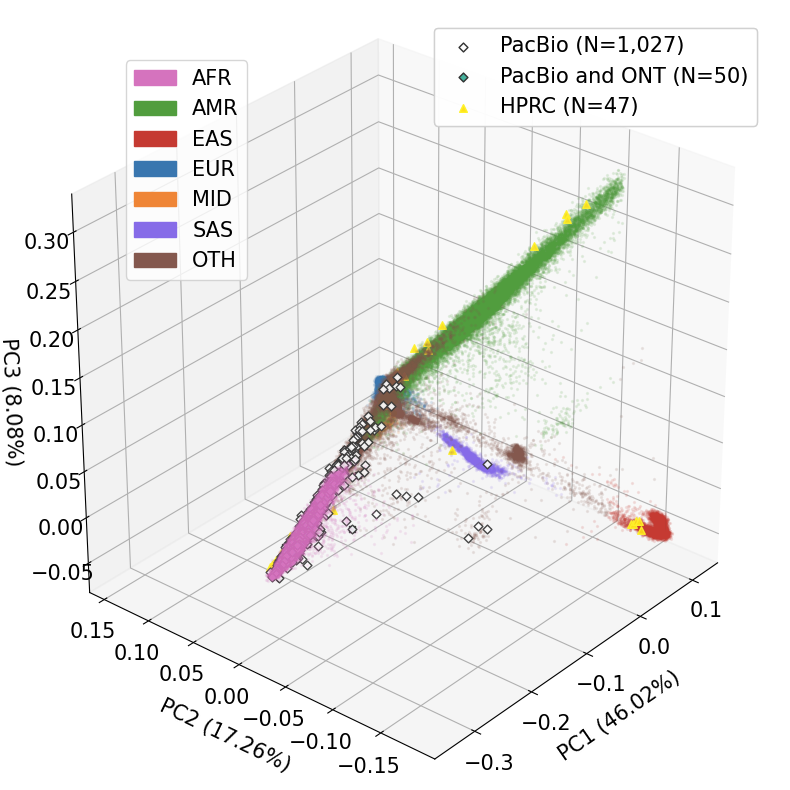

In [35]:
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect("equal")

#ax.scatter3D(pc1, pc2, pc3, s=2, marker='o', depthshade=False, c=[f'{color_map[item]}08' for item in l])

# Create a scatter plot for each population in the full dataset
for pop, color in color_map.items():
    # Filter points belonging to the current population
    indices = [i for i, item in enumerate(l1) if item == pop]
    ax.scatter3D(
        [pc1[i] for i in indices],
        [pc2[i] for i in indices],
        [pc3[i] for i in indices],
        s=2,
        marker='o',
        depthshade=False,
        color=color,
        alpha=0.1,
        label=pop  # Label for legend
    )

ax.set_xlabel(f"PC1 ({100.0*variance_explained[0]:.2f}%)", labelpad=10)
ax.set_ylabel(f"PC2 ({100.0*variance_explained[1]:.2f}%)", labelpad=10)
ax.set_zlabel(f"PC3 ({100.0*variance_explained[2]:.2f}%)", labelpad=10)

ax.view_init(30, -140, 0)

a1 = ax.scatter3D([pb_pc1[0]], [pb_pc2[0]], [pb_pc3[0]], s=20, depthshade=False, marker="D", color=pb_color, edgecolor=outer_color, label='PacBio (N=1,027)')
a2 = ax.scatter3D([ont_pc1[0]], [ont_pc2[0]], [ont_pc3[0]], s=20, depthshade=False, marker="D", color=pb_ont_color, edgecolor=outer_color, label='PacBio and ONT (N=50)')
a3 = ax.scatter3D([hprc_pc1[0]], [hprc_pc2[0]], [hprc_pc3[0]], s=30, depthshade=False, marker="^", color=hprc_color, edgecolor=hprc_outer_color, label='HPRC (N=47)')

ax.scatter3D(pb_pc1, pb_pc2, pb_pc3, s=20, depthshade=False, marker='D', color=pb_color, edgecolor=outer_color, alpha=0.9)
ax.scatter3D(ont_pc1, ont_pc2, ont_pc3, s=20, depthshade=False, marker='s', color=pb_ont_color, edgecolor=outer_color, alpha=0.9)
ax.scatter3D(hprc_pc1, hprc_pc2, hprc_pc3, s=30, depthshade=False, marker='^', color=hprc_color, edgecolor=hprc_outer_color, alpha=0.9)

legend_patches = [mpatches.Patch(color=color, label=pop.upper()) for pop, color in color_map.items()]
legend1 = ax.legend(handles=legend_patches, loc=(0.15, 0.65))
plt.gca().add_artist(legend1)

legend2 = ax.legend(handles=[a1, a2, a3], loc=(0.55, 0.85))
plt.gca().add_artist(legend2)

plt.savefig('pca_3d.proj.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [43]:
!ls *.pdf

pca_2d_grey.proj.pdf  pca_2d.proj.pdf  pca_3d.proj.pdf	pca_two_panel.proj.pdf


In [36]:
!gsutil -m cp *.pdf {bucket}/scratch/kvg/

Copying file://pca_2d_grey.proj.pdf [Content-Type=application/pdf]...
Copying file://pca_2d.proj.pdf [Content-Type=application/pdf]...                
/ [2/2 files][  7.0 MiB/  7.0 MiB] 100% Done                                    
Operation completed over 2 objects/7.0 MiB.                                      
